Train different deep learning models on shopping products category classification dataset.

- Naive Bag of Words: these simply pool the embeddings of all words in the sentence and predict using that
    - NBW-vanilla: simply train a network form scratch. Ensure that it doesn't overfit/underfit
    - NBW-pretrained
        - NBW-pretrained-static: use pretrained embeddings and don't update them
        - NBW-pretrained-finetuned: use pretrained embeddings and update them
    - visualize the embeddings
        - which words are associated with different categories?
        - how much of the variance in embedding space is explained by the 1-d subspace learnt by the last layer?
- Simple Bayes LM: train a feedforward NLM on each class. Predict based on which class gives higher probability
    - SBLM-vanilla: simply train a network from scratch. Ensure that it doesn't overfit/underfit
    - SBLM-pretrained
        - SBLM-pretrained-static: use pretrained embeddings and don't update them
        - SBLM-pretrained-finetuned: use pretrained embeddings and update them
    - SBLM-ngram: no deep learning, just use n-gram probabilities with witten-bell smoothing
    - compare text generation capabilities of SBLM-ngram with deep learning variants
    - are deep learning based models able to model language well?
- BERT: train a BERT model on the dataset
    - BERT-pretrained-static: use pretrained BERT embeddings and don't update them
    - BERT-pretrained-finetuned: use pretrained BERT embeddings and update them
    - is it able to achieve sota performance?
    - cluster contextual embeddings and visualize them
    - understand sentence embeddings
        - cluster sentence embeddings and visualize them. What kind of sentences are close to each other?
        - check linear algebra quantities
            - spaces: null space, row space, column space, left null space, SVD
            - eigenvalues and eigen vectors
- GPT: prompt engineering in GPT
    - GPT-3.5 Turbo
    - GPT-4
    - which is the simplest model that can solve the task?

In [15]:
# ml
from sklearn.model_selection import train_test_split

# nlp
import nltk

# deep learning
import torch
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from torch import nn
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, AutoModel

# local imports
import importlib
# add '../../deep_learning/src/' to path
import sys
sys.path.insert(1, '../../')
import deep_learning.src.nlp.models as nlp_models
_ = importlib.reload(nlp_models)

import deep_learning.src.nlp.training as nlp_training
_ = importlib.reload(nlp_training)

import deep_learning.src.nlp.preprocessing as local_preprocessing
_ = importlib.reload(local_preprocessing)

import deep_learning.src.nlp.analysis as dl_analysis
_ = importlib.reload(dl_analysis)

# basic data analysis
import pandas as pd
import numpy as np
import re, string
from IPython.display import display, HTML
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

96526 24132 51710


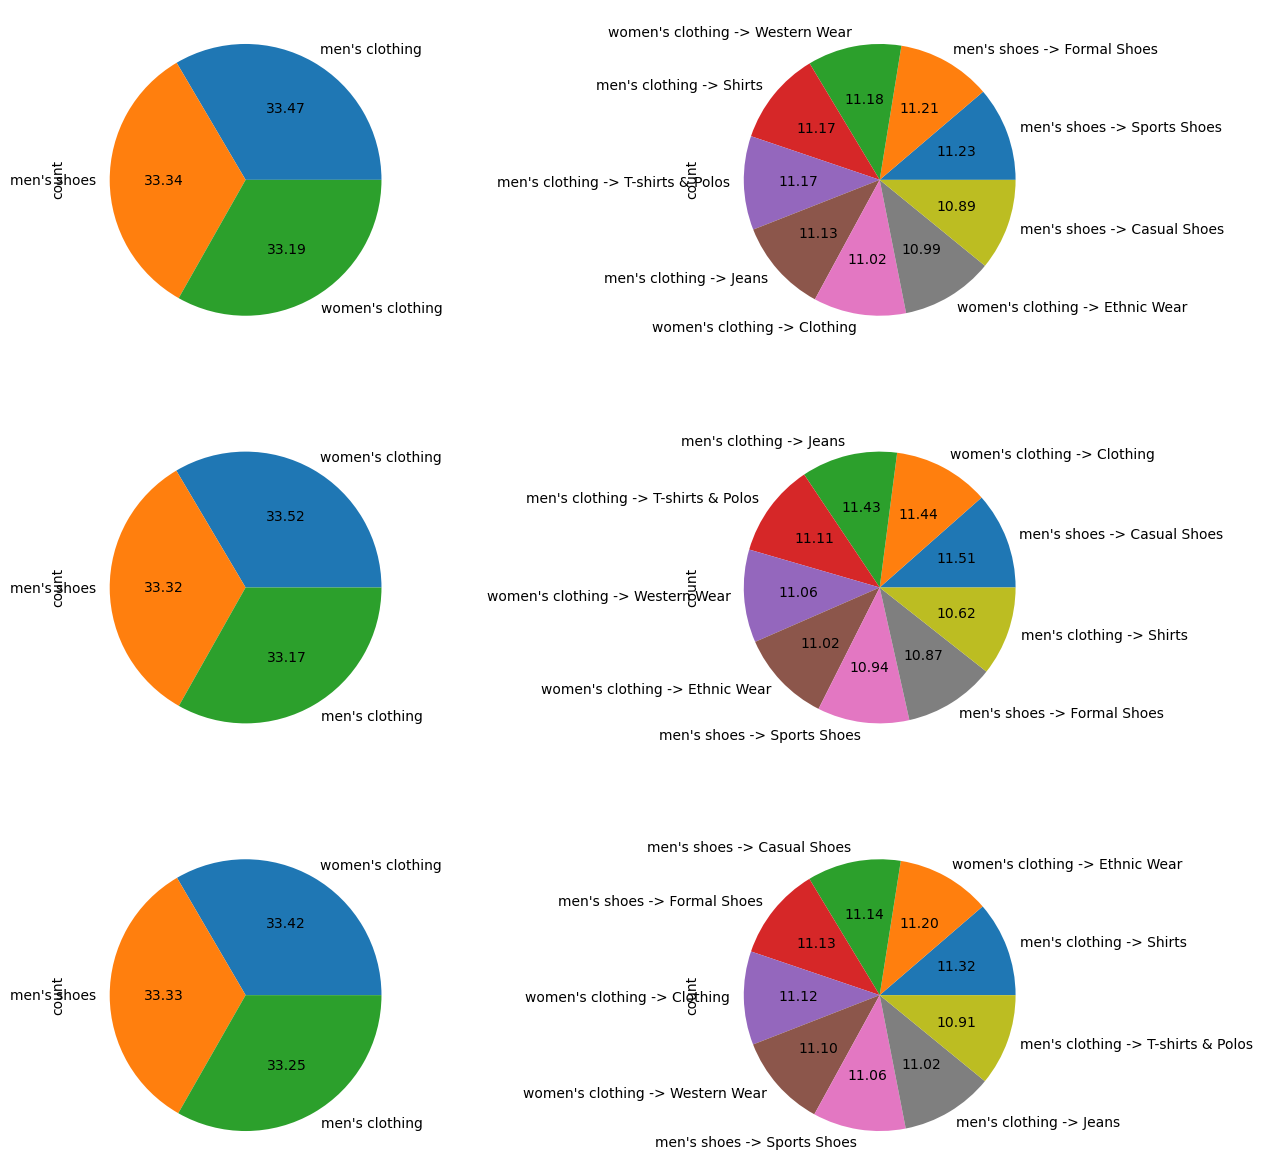

In [2]:
data_dir = '../../datasets/shopping/local/AmazonProducts2023/train_test_split/'
train_data = pd.read_csv(data_dir+'clothing_and_shoes_train.csv')
test_data = pd.read_csv(data_dir+'clothing_and_shoes_test.csv')

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
print (len(train_data), len(val_data), len(test_data))
# plot a grid of pie charts with 3 rows and 2 columns
# rows are for training, validation and test data and columns are for main and sub categories
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

for i, data in enumerate([train_data, val_data, test_data]):
    data['main_category'].value_counts().plot.pie(autopct='%.2f', ax=ax[i][0])
    data['sub_category'].value_counts().plot.pie(autopct='%.2f', ax=ax[i][1])

plt.show()

Build a classifier at the main category level

In [16]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
vocab = tokenizer.get_vocab()
id_to_token = {v:k for k,v in vocab.items()}
print (f"There are {len(vocab)} tokens in vocab")
print (f"Id of the unk token: {vocab['[UNK]']}")
print (f"Id of the pad token: {vocab['[PAD]']}", end='\n\n')

There are 28996 tokens in vocab
Id of the unk token: 100
Id of the pad token: 0



In [19]:
# construct a hugging face dataset out of the data

In [6]:
train_data.iloc[0]

Unnamed: 0                                                    17293
name              Dressitude Women Off-White Self-Design Cotton ...
main_category                                      women's clothing
sub_category                       women's clothing -> Western Wear
image             https://m.media-amazon.com/images/I/61xNhotNvK...
link              https://www.amazon.in/Dressitude-Off-White-Sel...
ratings                                                         NaN
no_of_ratings                                                   NaN
discount_price                                                 ₹599
actual_price                                                 ₹1,599
Name: 57214, dtype: object

In [13]:
name = train_data.iloc[0]['name']
output = tokenizer(name, padding='max_length', truncation=True, max_length=64)

In [14]:
tokens = [id_to_token[i] for i in output['input_ids']]
print (name)
print (tokens)

Dressitude Women Off-White Self-Design Cotton Shrug_2509OWH
['[CLS]', 'Dr', '##ess', '##itude', 'Women', 'Off', '-', 'White', 'Self', '-', 'Design', 'Cotton', 'S', '##hr', '##ug', '_', '250', '##9', '##OW', '##H', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
